## from github TimeSeries Notebooks collections

In [1]:
import itertools
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings
from pylab import rcParams
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [2]:
%matplotlib inline
rcParams['figure.figsize'] = 15, 10
warnings.filterwarnings('ignore')

In [3]:
file_path = 'airline.csv'
df = pd.read_csv('../data/consumption.csv', delimiter=';')
df.columns = ['date', 'Data']
df['date'] = pd.to_datetime(df['date'], format="%d/%m/%Y")
df.head(3)

,date,Data
0,2021-01-01,1516211
1,2021-01-02,1624051
2,2021-01-03,1604040


In [4]:
df.set_index(pd.to_datetime(df.date, format="%Y-%m-%D"), drop=True, inplace=True)
df.drop('date', axis=1, inplace=True)
df.head()

,Data
date,
2021-01-01,1516211
2021-01-02,1624051
2021-01-03,1604040
2021-01-04,1814433
2021-01-05,1871208


In [5]:
df_germany = df.sort_index()
df_germany.tail(10)

,Data
date,
2024-01-22,1621271
2024-01-23,1548858
2024-01-24,1440256
2024-01-25,1415383
2024-01-26,1405525
2024-01-27,1366601
2024-01-28,1362569
2024-01-29,1451603
2024-01-30,1441343


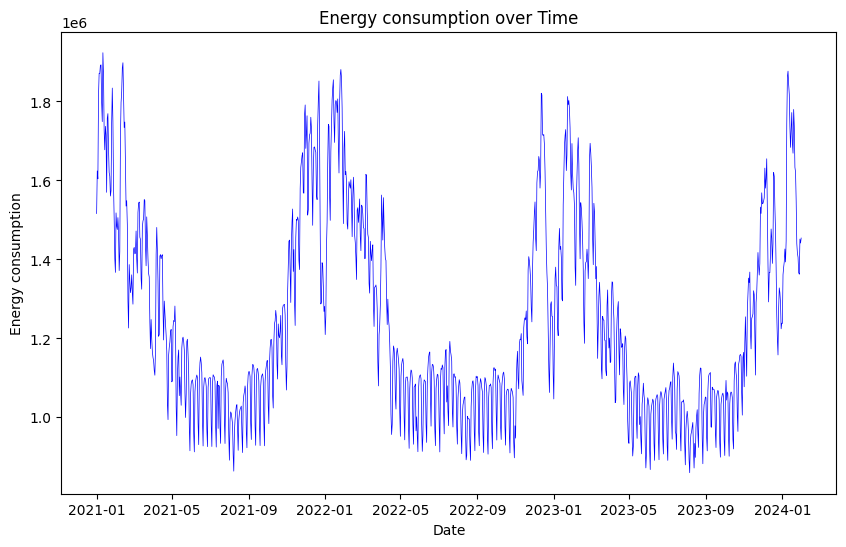

In [6]:
plt.figure(figsize=(10, 6),dpi=100)

plt.plot(df_germany.index, df_germany.Data, linestyle='-', color='b', linewidth=0.5)
plt.title('Energy consumption over Time')
plt.xlabel('Date')
plt.ylabel('Energy consumption')
plt.show()

In [7]:
def stationarity_check(timeseries):
    
    # determine rolling statistics
    movingAverage = timeseries.rolling(window=50).mean()
    movingSTD = timeseries.rolling(window=50).std()
    
    # plot rolling statistics
    plt.figure(figsize=(10,5))
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(movingAverage, color='red', label='Rolling Mean')
    plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')
    elecom_test = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(elecom_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in elecom_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)



For a Time series to be stationary, the ADCF test should have:

    p-value should be low (according to the null hypothesis)
    The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics From the above ADCF test result, we can see that p-value(near to 0.18) is very large. Also critical values lower than Test Statistics. Hence, we can safely say that our Time Series at the moment is NOT STATIONARY



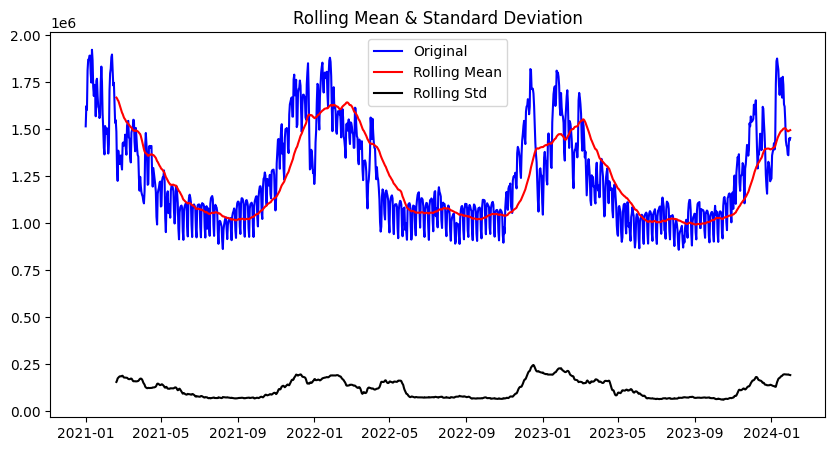

Results of Dickey Fuller Test:
Test Statistic                   -2.765911
p-value                           0.063311
#Lags Used                       22.000000
Number of Observations Used    1103.000000
Critical Value (1%)              -3.436293
Critical Value (5%)              -2.864164
Critical Value (10%)             -2.568167
dtype: float64


In [8]:
stationarity_check(df_germany.Data)

Que conclure sur la stationarité? Il faudrait une p-value faible, et apparemment des critical value proches du Test Statistic. Ici je sais pas vraiment ce qu'on peut qualifier de proche, voir l'exemple https://www.kaggle.com/code/sunaysawant/power-consumption-time-series-arima

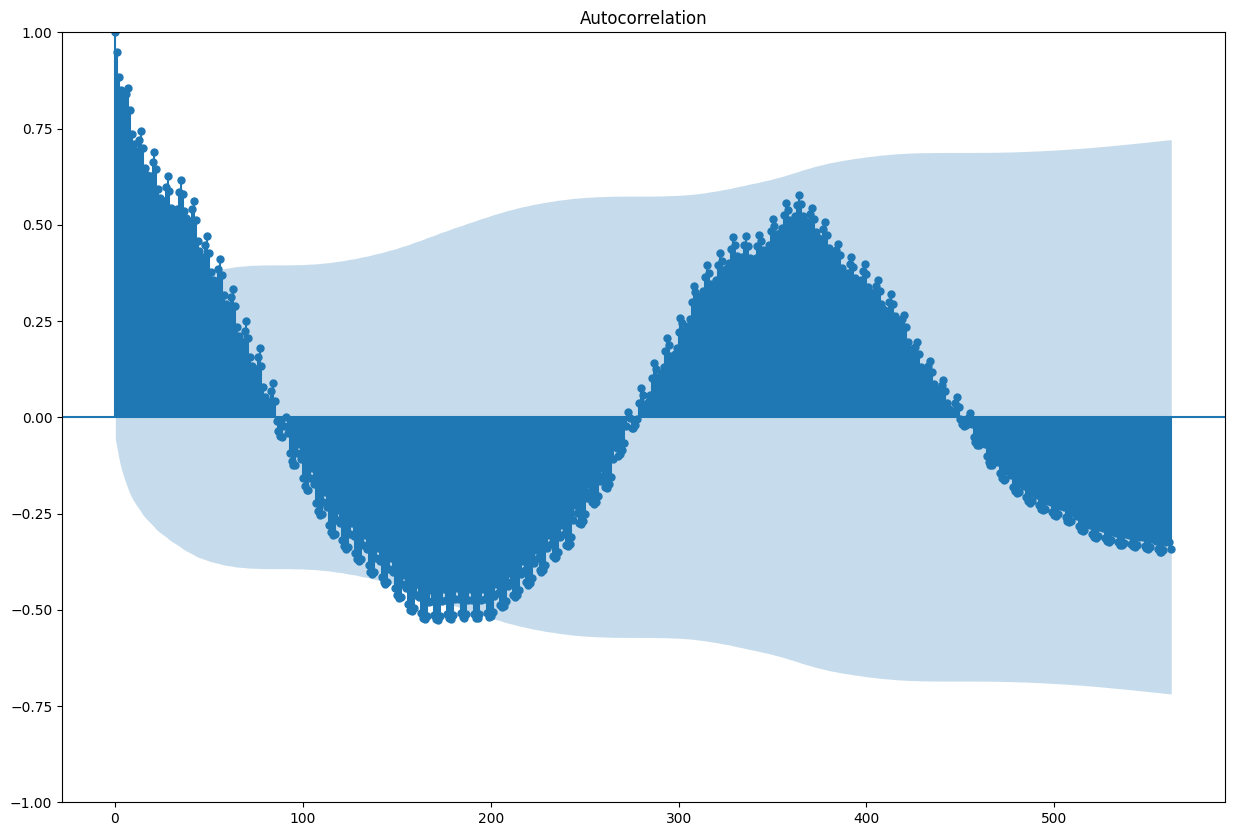

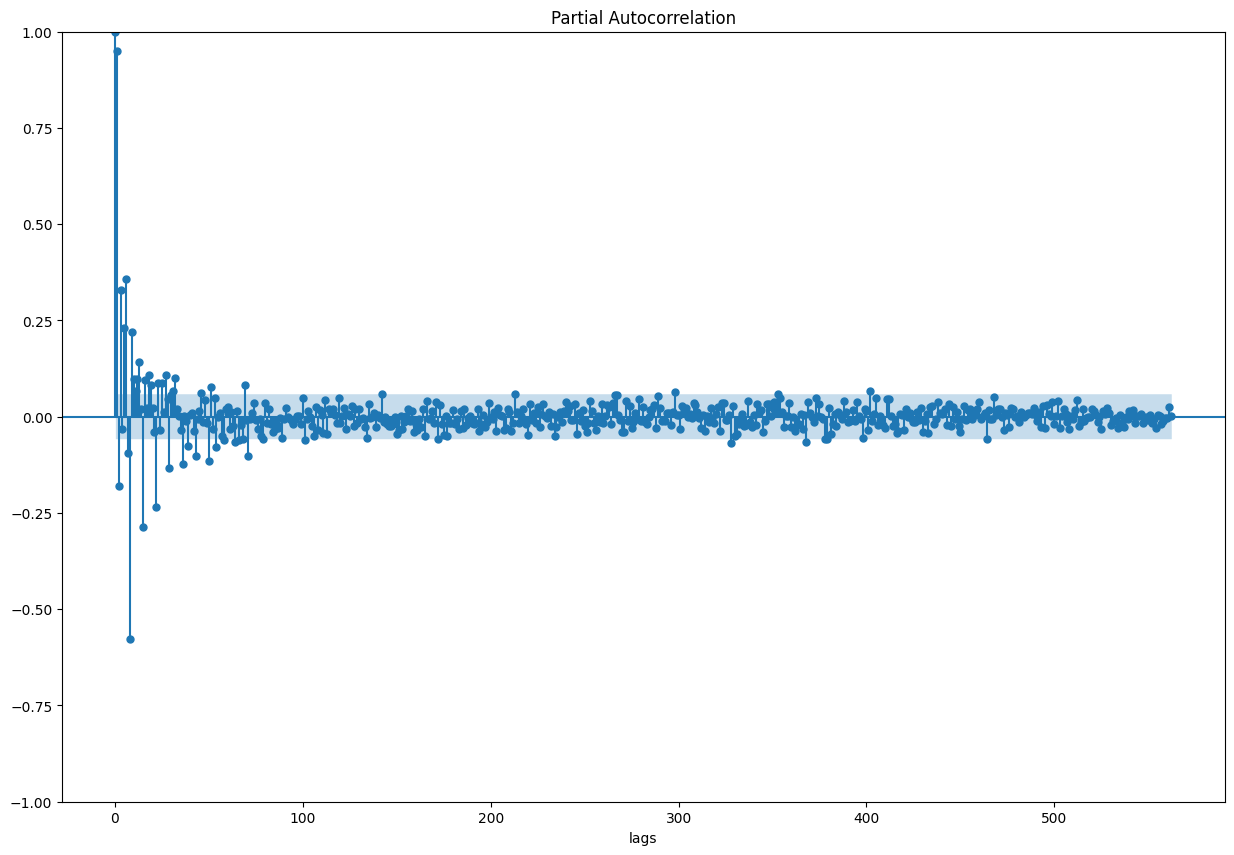

In [9]:
plot_acf(df_germany.Data, lags=562)
plot_pacf(df_germany.Data, lags=562)
plt.xlabel('lags')
plt.show()

Partial autocorrelation:

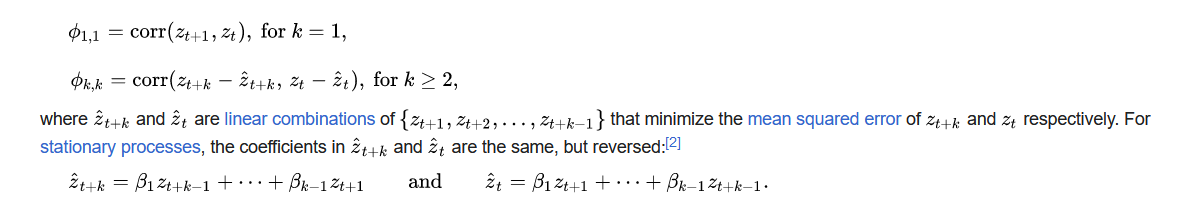

Take the log:

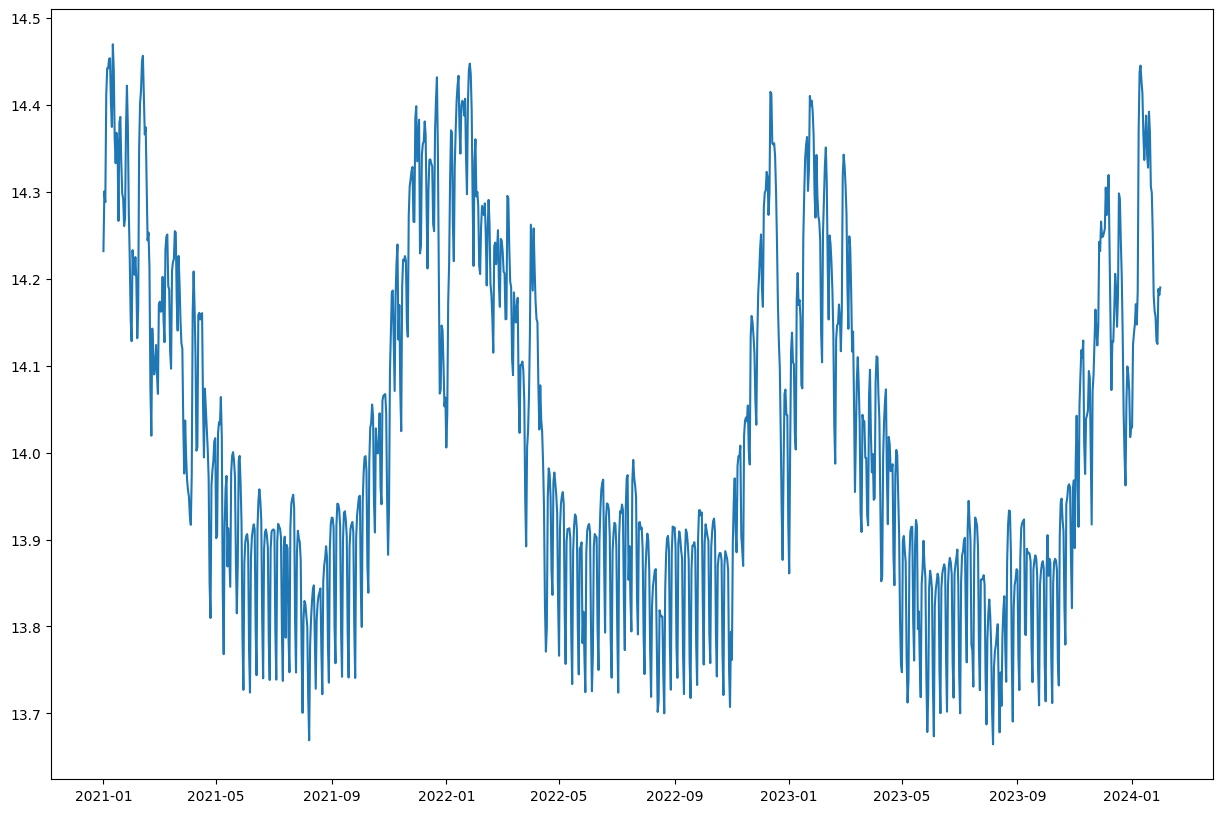

In [10]:
ts_log = np.log(df_germany['Data'])
plt.plot(ts_log)
ts_log_diff = ts_log - ts_log.shift()
# plt.plot(ts_log_diff)

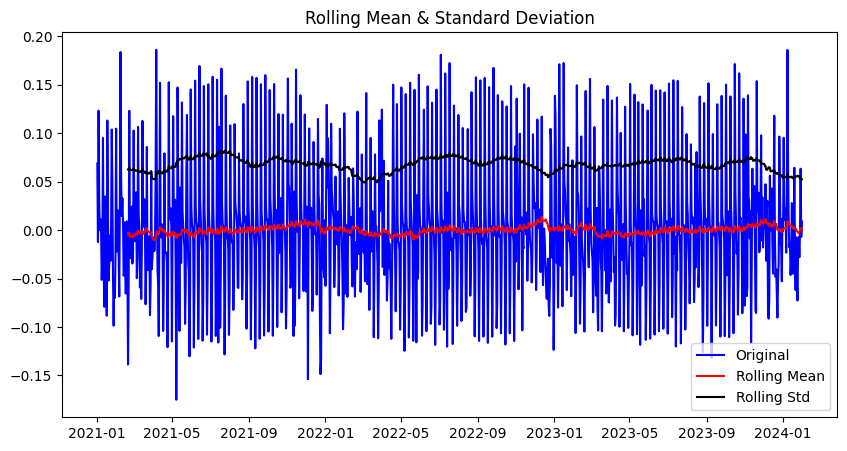

Results of Dickey Fuller Test:
Test Statistic                -7.818238e+00
p-value                        6.778804e-12
#Lags Used                     2.100000e+01
Number of Observations Used    1.103000e+03
Critical Value (1%)           -3.436293e+00
Critical Value (5%)           -2.864164e+00
Critical Value (10%)          -2.568167e+00
dtype: float64


In [11]:
ts_log_diff.dropna(inplace=True)
stationarity_check(ts_log_diff)

In [12]:
p = q =range(1,4)
pq = itertools.product(p, q)
for param in pq:
    try:
        mod = ARMA(ts_log_diff,order=param)
        results = mod.fit()
        print('ARMA{} - AIC:{}'.format(param, results.aic))
    except:
        continue

In [13]:
p = q = range(0, 4)
r = range(0,2)
pqr = itertools.product(p, r, q)
for param in pqr:
    try:
        mod = ARIMA(ts_log_diff,order=param)
        results = mod.fit()
        print('ARIMA{} - AIC:{} - MSE:{}'.format(param, results.aic, np.sum(np.square(results.resid))))
    except:
        continue

In [14]:
mod = sm.tsa.statespace.SARIMAX(ts_log_diff,
                                order = (1, 1, 0),
                                seasonal_order= (0,0,0,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.03140D+00    |proj g|=  1.34610D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     10      1     0     0   1.306D-03  -1.031D+00
  F =  -1.0314014992500420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


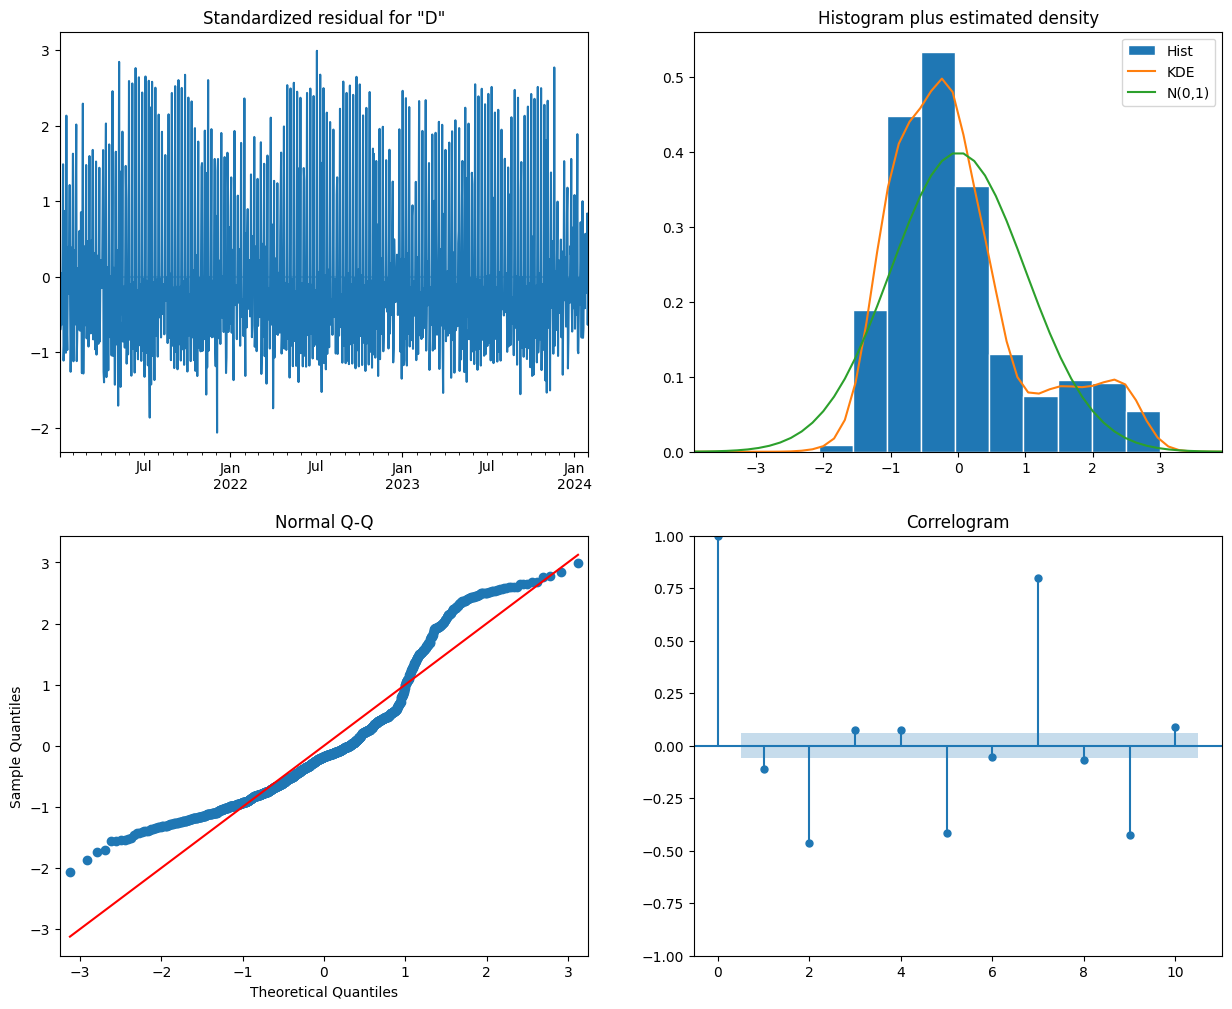

In [15]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()